In [1]:
import torch
import struct
import numpy as np
import matplotlib.pyplot as plt
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images
from torch.cuda.amp import autocast

device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

In [2]:
# Initialize the model and load the pretrained weights.
# This will automatically download the model weights the first time it's run, which may take a while.
model = VGGT()
_URL = "https://huggingface.co/facebook/VGGT-1B/resolve/main/model.pt"
model.load_state_dict(torch.hub.load_state_dict_from_url(_URL))
model.to(device)

VGGT(
  (aggregator): Aggregator(
    (patch_embed): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-23): 24 x NestedTensorBlock(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU(approximate=

In [ ]:
SCENE="truck"
SKIP=10

if SCENE=="banana": 
    # Load and preprocess example images (replace with your own image paths)
    image_names = [
        "/home/skhalid/Documents/data/banana/input/frame_00001.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00002.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00003.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00004.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00005.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00006.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00007.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00008.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00009.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00010.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00011.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00012.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00013.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00014.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00015.JPG", 
        "/home/skhalid/Documents/data/banana/input/frame_00016.JPG"
    ]
    ### BANANA
    width = 3008
    height = 2000
    BASE_PATH = "/home/skhalid/Documents/data/banana"
    INTRINSICS_BINARY_PATH = BASE_PATH+"/sparse/0/cameras.bin"
    EXTRINSICS_BINARY_PATH = BASE_PATH+"/sparse/0/images.bin"
    PTS_PATH = BASE_PATH+"/sparse/0/points3D.ply"
    PREFIX = "frame_"
    START_ID = 0
    N = 200_000

elif SCENE=="lego": 
    ### LEGO
    image_names = ["/home/skhalid/Documents/data/nerf_synthetic/lego/train/r_"+str(v)+".png" for v in range(0, 99, SKIP)]
    width = 800
    height = 800
    BASE_PATH = "/home/skhalid/Documents/data/nerf_synthetic/lego/"
    INTRINSICS_BINARY_PATH = BASE_PATH+"/sparse/0/cameras.bin"
    EXTRINSICS_BINARY_PATH = BASE_PATH+"/sparse/0/images.bin"
    PTS_PATH = BASE_PATH+"/sparse/0/points3D.ply"
    PREFIX = "r_"
    START_ID = 0
    N = 200_000

elif SCENE=="bicycle": 
    ### BICYCLE
    BASE="/home/skhalid/Documents/data/360_v2/bicycle/images_4/_DSC"
    image_names = [BASE+str(v)+".JPG" for v in range(8679, 8873, SKIP)]
    width = 1236
    height = 821    
    BASE_PATH = "/home/skhalid/Documents/data/360_v2/bicycle"
    INTRINSICS_BINARY_PATH = BASE_PATH+"/sparse/0/cameras.bin"
    EXTRINSICS_BINARY_PATH = BASE_PATH+"/sparse/0/images.bin"
    PTS_PATH = BASE_PATH+"/sparse/0/points3D.ply"
    PREFIX = "_DSC"
    START_ID = 0
    N = 1_000_000
    # test_cases = ["8679.JPG",
    #               "8687.JPG",
    #               "8695.JPG",
    #               "8703.JPG",
    #               "8711.JPG",
    #               "8719.JPG",
    #               "8727.JPG",
    #               "8735.JPG",
    #               "8744.JPG",
    #               "8752.JPG",
    #               "8760.JPG",
    #               "8768.JPG",
    #               "8776.JPG",
    #               "8784.JPG",
    #               "8792.JPG",
    #               "8800.JPG",
    #               "8808.JPG",
    #               "8816.JPG",
    #               "8824.JPG",
    #               "8832.JPG",
    #               "8840.JPG",
    #               "8848.JPG",
    #               "8856.JPG",
    #               "8864.JPG",
    #               "8872.JPG"]
    # for test_case in test_cases:
    #     image_names.append(BASE+str(test_case))

elif SCENE=="truck": 
    ### BICYCLE
    BASE="/home/skhalid/Documents/data/tandt_db/tandt/truck/images/"
    image_names = [BASE+str(v).zfill(6)+".jpg" for v in range(1, 252, SKIP)]
    width = 1957
    height = 1091    
    BASE_PATH = "/home/skhalid/Documents/data/tandt_db/tandt/truck"
    INTRINSICS_BINARY_PATH = BASE_PATH+"/sparse/0/cameras.bin"
    EXTRINSICS_BINARY_PATH = BASE_PATH+"/sparse/0/images.bin"
    PTS_PATH = BASE_PATH+"/sparse/0/points3D.ply"
    PREFIX = ""
    START_ID = 0
    N = 1_000_000
    # test_cases = ["8679.JPG",
    #               "8687.JPG",
    #               "8695.JPG",
    #               "8703.JPG",
    #               "8711.JPG",
    #               "8719.JPG",
    #               "8727.JPG",
    #               "8735.JPG",
    #               "8744.JPG",
    #               "8752.JPG",
    #               "8760.JPG",
    #               "8768.JPG",
    #               "8776.JPG",
    #               "8784.JPG",
    #               "8792.JPG",
    #               "8800.JPG",
    #               "8808.JPG",
    #               "8816.JPG",
    #               "8824.JPG",
    #               "8832.JPG",
    #               "8840.JPG",
    #               "8848.JPG",
    #               "8856.JPG",
    #               "8864.JPG",
    #               "8872.JPG"]
    # for test_case in test_cases:
    #     image_names.append(BASE+str(test_case))


In [4]:
import torch
from tqdm import tqdm

def run_batched_camera_inference(model, image_names, batch_size=8, device='cuda', dtype=torch.float16):
    from vggt.utils.pose_enc import pose_encoding_to_extri_intri
    from vggt.utils.geometry import unproject_depth_map_to_point_map
    # from vggt.utils.io import load_and_preprocess_images

    all_extrinsics = []
    all_intrinsics = []
    all_world_points = []
    depth_maps = []
    depth_conf_maps = []
    batch_tensors = []

    # Batch the rest of the images
    print(f"Processing the rest of {len(image_names)} images in batches of {batch_size}...")
    for i in tqdm(range(0, len(image_names), batch_size)):
        batch_names = image_names[i:i + batch_size]
        batch_tensor = load_and_preprocess_images(batch_names).to(device)

        if i==0:
            first_image = batch_tensor[0]
            print("first_image.shape: {}".format(batch_tensor.shape))
        else:
            # Add the first reference image to this batch as well
            batch_tensor = torch.cat((first_image[None], batch_tensor), dim=0)

        with torch.no_grad(), torch.cuda.amp.autocast(dtype=dtype):
            batch_tensor = batch_tensor[None]  # Add batch dim
            agg_tokens, ps_idx = model.aggregator(batch_tensor)

            pose_enc = model.camera_head(agg_tokens)[-1]
            extrinsic, intrinsic = pose_encoding_to_extri_intri(pose_enc, batch_tensor.shape[-2:])

            depth_map, depth_conf_map = model.depth_head(agg_tokens, batch_tensor, ps_idx)
            
            point_map_unproj = unproject_depth_map_to_point_map(depth_map.squeeze(0), extrinsic.squeeze(0), intrinsic.squeeze(0))
    
            # if i==0:    
            #     print("batch: {} | point_map_unproj.shape: {}".format(i, point_map_unproj.shape))
            # else:
            #     print("batch: {} | point_map_unproj[1:, ...].shape: {}".format(i, point_map_unproj[1:, ...].shape))

            if i==0:
                all_extrinsics.append(extrinsic[0, ...])
                all_intrinsics.append(intrinsic[0, ...])
                all_world_points.append(point_map_unproj)
                depth_maps.append(depth_map[0, ...])
                depth_conf_maps.append(depth_conf_map[0, ...])
                batch_tensors.append(batch_tensor[0, ...])
            else:
                all_extrinsics.append(extrinsic[0, 1:])
                all_intrinsics.append(intrinsic[0, 1:])
                all_world_points.append(point_map_unproj[1:, ...])
                depth_maps.append(depth_map[0, 1:, ...])
                depth_conf_maps.append(depth_conf_map[0, 1:, ...])
                batch_tensors.append(batch_tensor[0, 1:, ...])

            # print("extrinsic: {}".format(extrinsic.shape))
            # print("intrinsic: {}".format(intrinsic.shape))
            # print("point_map_unproj: {}".format(point_map_unproj.shape))
            # print("depth_map: {}".format(depth_map.shape))
            # print("depth_conf_map: {}".format(depth_conf_map.shape))
            # print("batch_tensor: {}".format(batch_tensor.shape))

    # Stack everything
    batch_tensors = torch.cat(batch_tensors)  # [N, 4, 4]
    all_extrinsics = torch.cat(all_extrinsics)  # [N, 4, 4]
    all_intrinsics = torch.cat(all_intrinsics)  # [N, 3, 3]
    all_world_points = np.concatenate(all_world_points)  # [N, H, W, 3]
    depth_maps = torch.cat(depth_maps, dim=0)  # [N, H, W, 3]
    depth_conf_maps = torch.cat(depth_conf_maps, dim=0)  # [N, H, W, 3]

    return {
        "all_extrinsics": all_extrinsics, 
        "all_intrinsics": all_intrinsics, 
        "all_world_points": all_world_points,
        "depth_maps": depth_maps,
        "depth_conf_maps": depth_conf_maps,
        "all_images": batch_tensors
    }

    # # Predict Tracks
    # # choose your own points to track, with shape (N, 2) for one scene
    # query_points = torch.FloatTensor([[100.0, 200.0], 
    #                                     [60.72, 259.94]]).to(device)
    # track_list, vis_score, conf_score = model.track_head(aggregated_tokens_list, images, ps_idx, query_points=query_points[None])

In [5]:
BATCH_SIZE=5

predictions = run_batched_camera_inference(model, image_names, batch_size=BATCH_SIZE)

Processing the rest of 16 images in batches of 5...


  0%|          | 0/4 [00:00<?, ?it/s]

first_image.shape: torch.Size([5, 3, 350, 518])


/tmp/ipykernel_3537890/3553435704.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=dtype):
100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


In [6]:
all_extrinsics = predictions["all_extrinsics"].cpu().numpy()
all_intrinsics = predictions["all_intrinsics"].cpu().numpy()
all_world_points = predictions["all_world_points"]
depth_maps = predictions["depth_maps"].cpu().numpy()
depth_conf_maps = predictions["depth_conf_maps"].cpu().numpy()
all_images = predictions["all_images"].cpu().numpy()

print(all_extrinsics.shape, all_intrinsics.shape, all_world_points.shape, depth_maps.shape, depth_conf_maps.shape, all_images.shape)

(16, 3, 4) (16, 3, 3) (16, 350, 518, 3) (16, 350, 518, 1) (16, 350, 518) (16, 3, 350, 518)


{'scores': tensor([0.2780, 0.2775], device='cuda:0'), 'labels': tensor([ 2, 13], device='cuda:0'), 'boxes': tensor([[1.9809e+00, 9.0944e+00, 3.0040e+03, 1.9989e+03],
        [5.3083e+02, 4.5452e+02, 2.1161e+03, 1.5238e+03]], device='cuda:0')}
fruit: 0.28 at box [ 530  454 2116 1523]


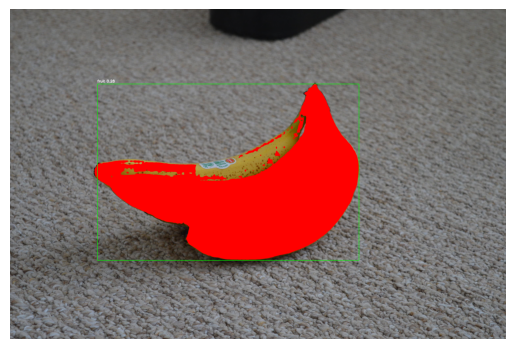

{'scores': tensor([0.2935, 0.2373], device='cuda:0'), 'labels': tensor([ 2, 13], device='cuda:0'), 'boxes': tensor([[ 8.5336e+00, -7.4345e-01,  3.0112e+03,  1.9881e+03],
        [ 7.0166e+02,  4.0618e+02,  2.2803e+03,  1.5075e+03]], device='cuda:0')}
fruit: 0.24 at box [ 701  406 2280 1507]


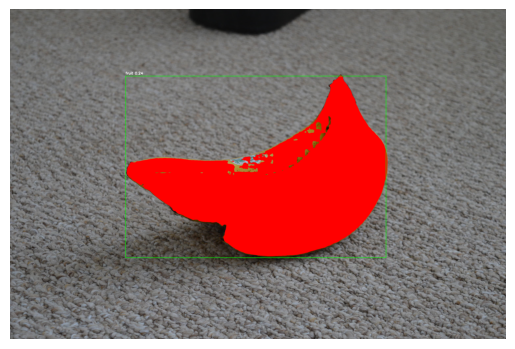

{'scores': tensor([0.2399, 0.2672], device='cuda:0'), 'labels': tensor([ 2, 13], device='cuda:0'), 'boxes': tensor([[1.0255e+01, 1.3171e+00, 3.0138e+03, 1.9774e+03],
        [4.4058e+02, 1.5587e+02, 2.5658e+03, 1.6163e+03]], device='cuda:0')}
fruit: 0.27 at box [ 440  155 2565 1616]


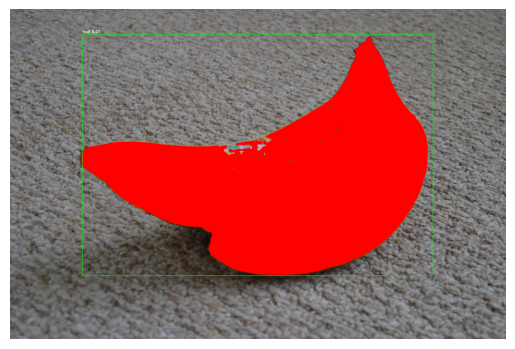

{'scores': tensor([0.2489, 0.2547], device='cuda:0'), 'labels': tensor([ 2, 13], device='cuda:0'), 'boxes': tensor([[  18.2098,   13.2548, 3021.7136, 1994.8969],
        [ 271.4197,  436.6861, 2181.6489, 1643.3683]], device='cuda:0')}
fruit: 0.25 at box [ 271  436 2181 1643]


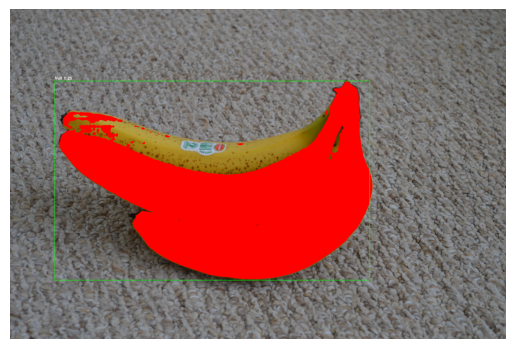

{'scores': tensor([0.2317, 0.2659], device='cuda:0'), 'labels': tensor([ 2, 13], device='cuda:0'), 'boxes': tensor([[  14.4821,   10.6039, 3017.3601, 1990.9651],
        [ 240.8281,  353.3484, 1943.2434, 1511.1339]], device='cuda:0')}
fruit: 0.27 at box [ 240  353 1943 1511]


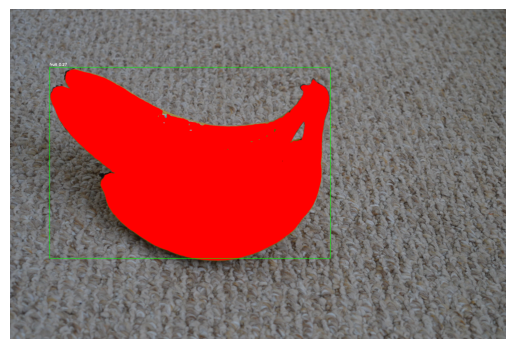

{'scores': tensor([0.2160, 0.2782], device='cuda:0'), 'labels': tensor([ 2, 13], device='cuda:0'), 'boxes': tensor([[ -11.4257,   14.1253, 2991.9685, 1998.7648],
        [ 877.2211,  228.0012, 2206.0310, 1574.7664]], device='cuda:0')}
fruit: 0.28 at box [ 877  228 2206 1574]


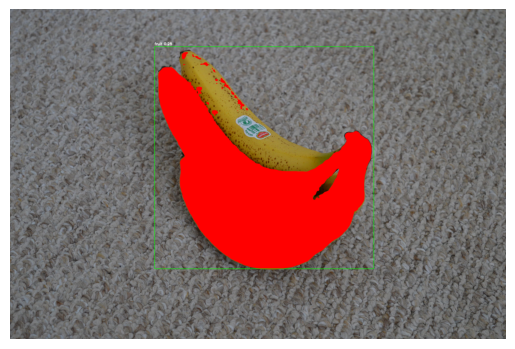

{'scores': tensor([0.2491, 0.2967], device='cuda:0'), 'labels': tensor([ 2, 13], device='cuda:0'), 'boxes': tensor([[   7.6075,   11.7158, 3008.4290, 1996.9558],
        [ 942.9597,  312.4241, 1924.5402, 1598.5369]], device='cuda:0')}
fruit: 0.30 at box [ 942  312 1924 1598]


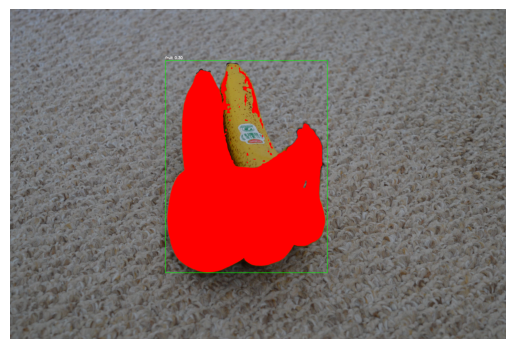

{'scores': tensor([0.2519, 0.2511], device='cuda:0'), 'labels': tensor([ 2, 13], device='cuda:0'), 'boxes': tensor([[   4.0297,   17.9610, 3007.8965, 1999.5902],
        [ 845.7067,  157.9416, 2051.6494, 1446.7661]], device='cuda:0')}
fruit: 0.25 at box [ 845  157 2051 1446]


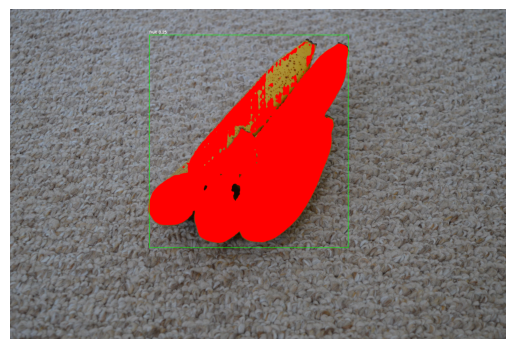

{'scores': tensor([0.2635, 0.2165], device='cuda:0'), 'labels': tensor([ 2, 13], device='cuda:0'), 'boxes': tensor([[  -4.8571,    9.0516, 2998.0437, 1999.4395],
        [ 893.2919,  291.9974, 1793.4351, 1649.6145]], device='cuda:0')}
fruit: 0.22 at box [ 893  291 1793 1649]


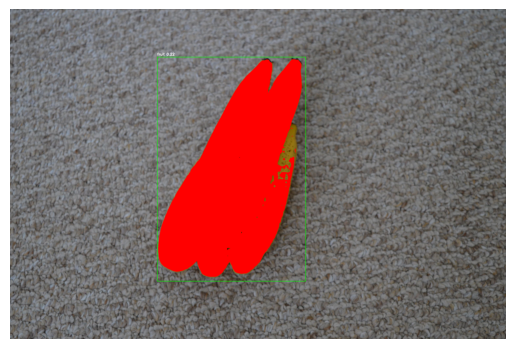

{'scores': tensor([0.2215, 0.2612], device='cuda:0'), 'labels': tensor([ 2, 13], device='cuda:0'), 'boxes': tensor([[ -10.7592,  -10.2413, 2992.6338, 1976.3354],
        [ 242.2595,  356.5006, 2212.7698, 1328.0723]], device='cuda:0')}
fruit: 0.26 at box [ 242  356 2212 1328]


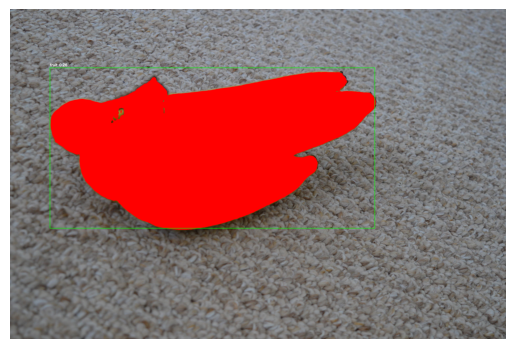

{'scores': tensor([0.2155], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'boxes': tensor([[-4.6607e-01,  5.5563e+00,  3.0019e+03,  1.9961e+03]], device='cuda:0')}
{'scores': tensor([0.2114, 0.2273], device='cuda:0'), 'labels': tensor([ 2, 13], device='cuda:0'), 'boxes': tensor([[   8.2880,   38.2371, 3011.0400, 1993.2401],
        [1043.2279,  215.7534, 2761.7400, 1601.3511]], device='cuda:0')}
fruit: 0.23 at box [1043  215 2761 1601]


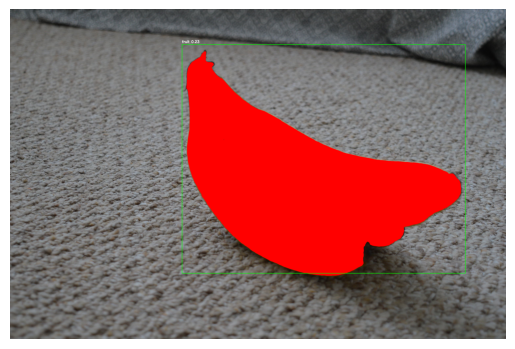

{'scores': tensor([0.2745, 0.2211], device='cuda:0'), 'labels': tensor([ 2, 13], device='cuda:0'), 'boxes': tensor([[  -5.0262,   15.9708, 2997.6167, 2003.7866],
        [1333.1338,    4.6919, 2118.0693, 1460.3584]], device='cuda:0')}
fruit: 0.22 at box [1333    4 2118 1460]


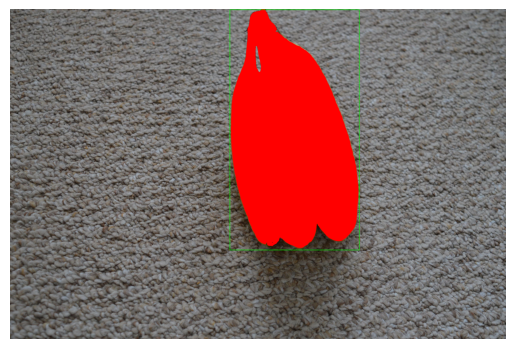

{'scores': tensor([0.2380, 0.2022], device='cuda:0'), 'labels': tensor([ 2, 13], device='cuda:0'), 'boxes': tensor([[-2.5614e+00,  6.8331e+00,  3.0002e+03,  1.9982e+03],
        [ 1.0165e+03,  9.9629e+01,  1.9861e+03,  1.6344e+03]], device='cuda:0')}
fruit: 0.20 at box [1016   99 1986 1634]


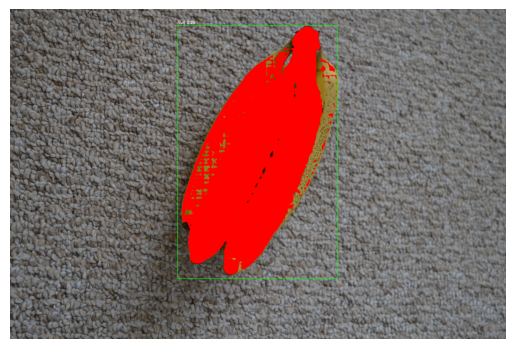

{'scores': tensor([0.2512, 0.2178], device='cuda:0'), 'labels': tensor([ 2, 13], device='cuda:0'), 'boxes': tensor([[ -25.1773,   15.5135, 2974.9331, 2006.6759],
        [ 399.8653,  250.9757, 1659.5425, 1800.4601]], device='cuda:0')}
fruit: 0.22 at box [ 399  250 1659 1800]


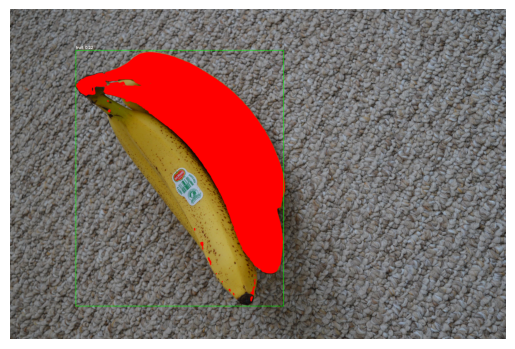

{'scores': tensor([0.2531, 0.2442], device='cuda:0'), 'labels': tensor([ 2, 13], device='cuda:0'), 'boxes': tensor([[   9.4380,   11.5412, 3012.7046, 1995.5570],
        [ 776.3489,   45.8968, 2489.7417, 1394.6940]], device='cuda:0')}
fruit: 0.24 at box [ 776   45 2489 1394]


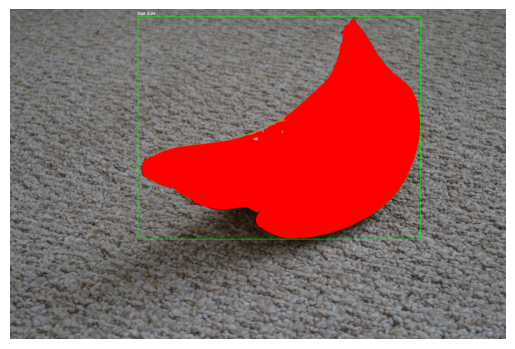

In [ ]:
'''
OBJECT_MASKING
'''
import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection
from segment_anything import sam_model_registry, SamPredictor
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load OWL-ViT
device = "cuda" if torch.cuda.is_available() else "cpu"
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-large-patch14").to(device)
processor = OwlViTProcessor.from_pretrained("google/owlvit-large-patch14")

# Load SAM
sam_checkpoint = "/home/skhalid/Downloads/sam_vit_l.pth"
sam = sam_model_registry["vit_l"](checkpoint=sam_checkpoint).to(device).eval()
predictor = SamPredictor(sam)

# Load image
SCORE_THRESHOLD = 0.2
# image_paths = ["/home/skhalid/Documents/data/tandt_db/tandt/truck/images/000001.jpg"]
# # image_paths = ["/home/skhalid/Documents/data/nerf_synthetic/lego/images/r_0.png"]
# # image_paths = ["/home/skhalid/Documents/data/bicycle/images_4/_DSC8679.JPG"]
# # image_paths = ["/home/skhalid/Documents/data/Synthetic4Relight/hotdog/train/000.png"]
# # image_paths = ["/home/skhalid/Documents/data/data_dtu/DTU_scan24/inputs/images/000000.png"]
# # image_paths = ["/home/skhalid/Documents/data/banana/images/frame_00002.JPG"]
# image_paths = []

object_masks = []

for image_path in image_names:
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)

    # Text prompt
    # texts = [["car", "bicycle", "trees", "grass", "ground", "bench", "lego", "fruit"]]  # You can modify this list
    texts = [["truck", "house", "ground", "tree", "chair", "building", "sky", "clouds", "road", "lego", "grass", "toy", "hotdog", "fruit", "food", "window"]]

    # Prepare input for OWL-ViT
    inputs = processor(text=texts, images=image, return_tensors="pt").to(device)

    # Detect with OWL-ViT
    # print("Begin detect")
    with torch.no_grad():
        outputs = model(**inputs)
    # print("End detect")

    # Get boxes and scores
    target_sizes = torch.tensor([image.size[::-1]]).to(device)
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=SCORE_THRESHOLD)[0]
    print(results)

    # Run SAM
    predictor.set_image(image_np)

    # Process each box from OWL-ViT
    for box, score, label in zip(results["boxes"], results["scores"], results["labels"]):
        if texts[0][label] == "truck":
            box = box.cpu().numpy().astype(int)
            x0, y0, x1, y1 = box
            print(f"{texts[0][label]}: {score:.2f} at box {box}")

            # SAM expects box in XYXY format
            input_box = np.array([x0, y0, x1, y1])
            masks, _, _ = predictor.predict(box=input_box[None, :], multimask_output=False)

            # Overlay mask
            mask = masks[0]
            overlay = image_np.copy()
            overlay[mask] = (255, 0, 0)  # Red mask

            # Draw bounding box
            cv2.rectangle(overlay, (x0, y0), (x1, y1), (0, 255, 0), 2)
            cv2.putText(overlay, f"{texts[0][label]} {score:.2f}", (x0, y0 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

            # Show
            plt.imshow(overlay)
            plt.axis("off")
            plt.show()

            resized_mask = cv2.resize(mask.astype(np.uint8), (depth_conf_maps[0].shape[1], depth_conf_maps[0].shape[0]), interpolation=cv2.INTER_NEAREST)
            resized_mask = resized_mask[None, ...].astype(np.float32)

    object_masks.append(resized_mask)

object_masks = np.concatenate((object_masks), axis=0)

# torch.cuda.empty_cache()

In [19]:
# print(mask.view(depth_conf_maps[0].shape[0], depth_conf_maps[0].shape[1]).shape, depth_conf_maps[0].shape)
print(mask.shape, resized_mask.shape, depth_conf_maps[0].shape, object_masks.shape)

(2000, 3008) (1, 350, 518) (350, 518) (16, 350, 518)


In [22]:
N = all_intrinsics.shape[0]
MASKING_MODE = "object"

for i in range(N):
    # filter out pixels
    if MASKING_MODE == "depth":
        conf_mask = depth_conf_maps[i]
    elif MASKING_MODE == "object":
        conf_mask = object_masks[i]
    else:
        assert MASKING_MODE == "depth" or MASKING_MODE == "object"

    conf_mask /= conf_mask.max()
    conf_mask[conf_mask<0.5] = 0.0
    conf_mask[conf_mask>0.0] = 1.0
    all_world_points[i, :] *= conf_mask[..., None]
    depth_maps[i, :] *= conf_mask[..., None]
    all_images[i, :] *= conf_mask[None, ...].astype(np.uint8)

In [23]:
import open3d as o3d
import numpy as np
import torch

def tsdf_fusion_from_tensors(depth_maps, all_intrinsics, all_extrinsics, images, mask, voxel_length=0.005, sdf_trunc=0.04):
    """
    depth_maps: torch tensor of shape (N, H, W, 1)
    all_intrinsics: torch tensor of shape (N, 3, 3)
    all_extrinsics: torch tensor of shape (N, 3, 4)
    """
    N, H, W, _ = depth_maps.shape
    volume = o3d.pipelines.integration.ScalableTSDFVolume(
        voxel_length=voxel_length,
        sdf_trunc=sdf_trunc,
        color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8)
    # volume = o3d.pipelines.integration.UniformTSDFVolume(
    #     length=300.0,  # 3m bounding cube
    #     resolution=512,
    #     sdf_trunc=0.04,
    #     color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8)

    for i in range(N):
        depth_np = depth_maps[i, ..., 0].astype(np.float32)  # (H, W)
        image = images[i, ...].astype(np.float32)
        depth_np = np.ascontiguousarray(depth_np, dtype=np.float32) * 1000.0
        image_np = np.ascontiguousarray(255 * image, dtype=np.uint8)

        # # filter out pixels
        # conf_mask = mask[i]
        # conf_mask /= conf_mask.max()
        # conf_mask[conf_mask<0.5] = 0.0
        # conf_mask[conf_mask>0.0] = 1.0
        # depth_np *= conf_mask
        # image_np *= conf_mask[..., None].astype(np.uint8) 

        depth_image = o3d.geometry.Image(depth_np)
        color_image = o3d.geometry.Image(image_np)

        # Dummy color image (white)
        rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(color_image, depth_image, convert_rgb_to_intensity=False)

        # Intrinsics
        K = all_intrinsics[i]
        intrinsic = o3d.camera.PinholeCameraIntrinsic()
        intrinsic.set_intrinsics(width=W, height=H, fx=K[0, 0], fy=K[1, 1], cx=K[0, 2], cy=K[1, 2])

        # # Extrinsics (convert to 4x4 matrix)
        # extrinsic = np.eye(4)
        # extrinsic[:3, :4] = all_extrinsics[i].cpu().numpy()
        # Extrinsics: convert 3x4 to 4x4 and invert
        extrinsic_3x4 = all_extrinsics[i]
        extrinsic_4x4 = np.eye(4)
        extrinsic_4x4[:3,:4] = extrinsic_3x4
        # extrinsic_4x4 = np.linalg.inv(extrinsic_4x4)

        # pcd = volume.extract_point_cloud()
        # o3d.visualization.draw_geometries([pcd])

        try:
            volume.integrate(rgbd, intrinsic, extrinsic_4x4)
        except Exception as e:
            print(f"Integration failed at frame {i}: {e}")

        # # Generate point cloud
        # pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
        #     rgbd, intrinsic, extrinsic_4x4)

        # print(f"[Frame {i}] #Points: {len(pcd.points)}")
        # o3d.visualization.draw_geometries([pcd])

        # plt.subplot(1, 2, 1)
        # plt.title("Color")
        # plt.imshow(np.asarray(rgbd.color))
        # plt.axis("off")

        # plt.subplot(1, 2, 2)
        # plt.title("Depth")
        # plt.imshow(np.asarray(rgbd.depth), cmap='gray')
        # plt.axis("off")
        # plt.show()

        # print(f"Frame {i}:")
        # print("  Depth min/max:", depth_np.min(), depth_np.max())
        # print("  K:\n", K)
        # print("  Extrinsic:\n", extrinsic_4x4)

        # mesh = volume.extract_triangle_mesh()
        # mesh.compute_vertex_normals()
        # if len(mesh.vertices) == 0:
        #     print("⚠️ Mesh is empty! TSDF fusion failed.")
        # else:
        #     print(f"✅ Mesh has {len(mesh.vertices)} vertices and {len(mesh.triangles)} triangles.")
        #     o3d.visualization.draw_geometries([mesh])

    pcd = volume.extract_point_cloud()
    o3d.visualization.draw_geometries([pcd])

    mesh = volume.extract_triangle_mesh()
    mesh.compute_vertex_normals()

    if len(mesh.vertices) == 0:
        print("⚠️ Mesh is empty! TSDF fusion failed.")
    else:
        print(f"✅ Mesh has {len(mesh.vertices)} vertices and {len(mesh.triangles)} triangles.")
        o3d.visualization.draw_geometries([mesh])

    return mesh

def visualize_surface(mesh):
    o3d.visualization.draw_geometries([mesh])

# Example usage
if __name__ == "__main__":    
    # Remove batch dim
    _depth = depth_maps  # shape: [17, 350, 518, 1]
    _all_intrinsics = all_intrinsics
    _all_extrinsics = all_extrinsics
    _all_images = all_images.transpose(0,2,3,1)

    # print(_all_intrinsics)
    print(_depth.shape, _all_intrinsics.shape, _all_extrinsics.shape, _all_images.shape)
    
    mask = depth_conf_maps
    mesh = tsdf_fusion_from_tensors(_depth, _all_intrinsics, _all_extrinsics, _all_images, mask)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
(16, 350, 518, 1) (16, 3, 3) (16, 3, 4) (16, 350, 518, 3)
✅ Mesh has 9331 vertices and 17086 triangles.


In [ ]:
import open3d as o3d
import numpy as np

def poisson_reconstruction_from_point_maps(point_maps, normal_maps, all_extrinsics, all_intrinsics, images, vis=True, depth=9):
    """
    Perform Poisson reconstruction from point and normal maps, and color the mesh using input RGB images.

    Args:
        point_maps: list of (H, W, 3) arrays of 3D points in world space.
        normal_maps: list of (H, W, 3) arrays of normals corresponding to the point maps.
        all_extrinsics: list of (4, 4) camera-to-world extrinsics.
        all_intrinsics: list of (3, 3) camera intrinsics.
        images: list of (H, W, 3) RGB images as NumPy arrays.
        vis: whether to visualize the resulting mesh.
        depth: octree depth for Poisson reconstruction (controls mesh detail).

    Returns:
        mesh: colored reconstructed Poisson mesh.
    """
    all_points = []
    all_normals = []
    
    for pts, norms in zip(point_maps, normal_maps):
        H, W, _ = pts.shape
        pts_flat = pts.reshape(-1, 3)
        norms_flat = norms.reshape(-1, 3)

        valid = np.isfinite(pts_flat).all(axis=1) & np.isfinite(norms_flat).all(axis=1)
        all_points.append(pts_flat[valid])
        all_normals.append(norms_flat[valid])

    all_points = np.concatenate(all_points, axis=0)
    all_normals = np.concatenate(all_normals, axis=0)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(all_points)
    pcd.normals = o3d.utility.Vector3dVector(all_normals)

    # Poisson reconstruction
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=depth)

    densities = np.asarray(densities)
    density_threshold = np.quantile(densities, 0.01)
    vertices_to_keep = densities > density_threshold
    mesh = mesh.select_by_index(np.where(vertices_to_keep)[0])
    mesh.compute_vertex_normals()
    mesh.paint_uniform_color([0.7, 0.7, 0.7])  # light gray

    # === Color the mesh using projections into the RGB images ===
    vertex_colors = np.zeros((len(mesh.vertices), 3))
    color_counts = np.zeros((len(mesh.vertices), 1))
    mesh_vertices = np.asarray(mesh.vertices)

    # for img, K, ext in zip(images, all_intrinsics, all_extrinsics):
    #     H, W, _ = img.shape
    #     world_to_cam = np.linalg.inv(ext)
    #     verts_cam = (world_to_cam[:3, :3] @ mesh_vertices.T + world_to_cam[:3, 3:4]).T

    #     proj = (K @ verts_cam.T).T
    #     proj[:, :2] /= (proj[:, 2:3] + 1e-8)
    #     uvs = proj[:, :2].astype(int)

    #     mask = (
    #         (uvs[:, 0] >= 0) & (uvs[:, 0] < W) &
    #         (uvs[:, 1] >= 0) & (uvs[:, 1] < H) &
    #         (verts_cam[:, 2] > 0)
    #     )

    #     valid_uvs = uvs[mask]
    #     sampled_colors = img[valid_uvs[:, 1], valid_uvs[:, 0]] / 255.0

    #     vertex_colors[mask] += sampled_colors
    #     color_counts[mask] += 1

    # color_counts[color_counts == 0] = 1
    # vertex_colors /= color_counts

    # mesh.vertex_colors = o3d.utility.Vector3dVector(vertex_colors)

    if vis:
        o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

    return mesh


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_normals_from_point_maps(depth_maps, all_intrinsics, all_extrinsics, point_maps, visualize=True):
    """
    Compute surface normals from point maps and optionally visualize them.

    Args:
        depth_maps: list of (H, W) depth maps.
        all_intrinsics: list of (3, 3) camera intrinsics.
        all_extrinsics: list of (4, 4) camera-to-world extrinsics.
        point_maps: list of (H, W, 3) 3D point maps in world space or camera space.
        visualize: whether to display normal maps using matplotlib.

    Returns:
        normal_maps: list of (H, W, 3) normal maps.
    """
    normal_maps = []

    for idx, points in enumerate(point_maps):
        H, W, _ = points.shape
        normals = np.zeros_like(points)

        # Compute spatial gradients
        dzdx = np.zeros_like(points)
        dzdy = np.zeros_like(points)

        dzdx[:, 1:-1] = (points[:, 2:] - points[:, :-2]) * 0.5
        dzdy[1:-1, :] = (points[2:, :] - points[:-2, :]) * 0.5

        # Compute normals using cross product
        n = np.cross(dzdx, dzdy)
        norm = np.linalg.norm(n, axis=2, keepdims=True) + 1e-8
        normals = n / norm

        # Flip normals to face the camera
        camera_pos = all_extrinsics[idx][:3, 3]  # camera position in world space
        to_camera = camera_pos[None, None, :] - points
        dot = np.sum(normals * to_camera, axis=-1)
        normals[dot < 0] *= -1  # flip normals pointing away

        normal_maps.append(normals)

        if visualize:
            # Normalize to [0, 1] for RGB visualization
            normal_img = (normals + 1.0) / 2.0  # [-1, 1] → [0, 1]
            normal_img = np.clip(normal_img, 0, 1)

            plt.figure(figsize=(6, 6))
            plt.imshow(normal_img)
            plt.title(f"Normal Map - Frame {idx}")
            plt.axis("off")
            plt.show()

    return normal_maps


In [ ]:
normal_maps = compute_normals_from_point_maps(
    depth_maps,
    all_intrinsics,
    all_extrinsics,
    all_world_points,
    visualize=True
)

mesh = poisson_reconstruction_from_point_maps(all_world_points, 
                                              normal_maps, 
                                              all_extrinsics, 
                                              all_intrinsics, 
                                              all_images, 
                                              vis=True, 
                                              depth=9)